# **Python Base. Pandas. Домашнее задание (HW)**
**Задача:**

*Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.*

Импортируем библиотеку Pandas:

In [1]:
import pandas as pd

Импортируем данные файлов train.csv, questions.csv, lectures.csv:
Для улучшения производительности задаем тип переменных и уменьшаем исходный размер файла train.csv:

In [2]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}
train=pd.read_csv('/content/drive/MyDrive/riiid-test-answer-prediction/train.csv', dtype=dtypes, nrows=20230332)
print("Train size:", train.shape)

Train size: (20230332, 10)


**Для дополнительного улучшения производительности количество строк исходного файла было сокращено.**

`TRAIN.CSV:`

Это основная таблица, которая связывает студента с вопросом или лекцией, с которыми он взаимодействует, а также дополнительная информация
об этом взаимодействии. Список колонок и краткое их описание:

* row_id: (int64) порядковый номер строки в этой таблице.
* timestamp: (int64) время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* user_id: (int32) идентификационный код ученика.
* content_id: (int16) идентификационный код вопроса или лекции.
* content_type_id: (int8) 0 если это вопрос, 1 если лекция.
11
* task_container_id: (int16) идентификационный код группы вопросов, в которой задан текущий вопрос.
* user_answer: (int8) вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* answered_correctly: (int8) правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1. Данное поле нужно будет предсказывать.
* prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* prior_question_had_explanation: (bool) смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.


In [4]:
lectures=pd.read_csv('/content/drive/MyDrive/riiid-test-answer-prediction/lectures.csv')

`LECTIONS.CSV`

Данная таблица аналогична таблице про вопросы, но она про лекции,
перейдем к ее описанию:

* lecture_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* type_of: краткое описание основной цели лекции.
* part: один из семи типов, который был в таблице с вопросами.
* tag: один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах.



In [5]:
questions=pd.read_csv('/content/drive/MyDrive/riiid-test-answer-prediction/questions.csv')

`QUESTIONS.CSV:`

Таблица описывающая вопрос. Количество вопросов в отличии от количества учеников заранее зафиксировано, также задания повторно предлагаются
различным ученикам. Список колонок:

* question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id: код по которому вопросы объединяются в группы.
* correct_answer: правильный ответ на вопрос.
* part: один из семи типов вопросов TOEIC. Ниже будет краткое описание каждого
* tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.


Данные прочитаны. Проверим их корректность посредством вывода 5 первых строк:

In [6]:
display(train.head(),lectures.head(),questions.head())

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Получим основную информацию из DF:

In [7]:
display(train.info(),lectures.info(),questions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20230332 entries, 0 to 20230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 656.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-nul

None

None

None

Определение типов переменных при чтении файла train.csv позволило уменьшить размер исходного файла.

Перейдем непосредственно к анализу наших данных.

Сколько значений пропущено?

In [8]:
print('Доля пропущенных значений в столбцах train:')
print(train.isnull().sum() / len(train))
print('Доля пропущенных значений в столбцах questions:')
print(questions.isnull().sum() / len(questions))
print('Доля пропущенных значений в столбцах lectures:')
print(lectures.isnull().sum() / len(lectures))

Доля пропущенных значений в столбцах train:
row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023387
prior_question_had_explanation    0.003903
dtype: float64
Доля пропущенных значений в столбцах questions:
question_id       0.000000
bundle_id         0.000000
correct_answer    0.000000
part              0.000000
tags              0.000074
dtype: float64
Доля пропущенных значений в столбцах lectures:
lecture_id    0.0
tag           0.0
part          0.0
type_of       0.0
dtype: float64


Сколько у нас пользователей?

In [11]:
print(train['user_id'].nunique())

79175


Сколько всего вопросов?

In [10]:
print(questions['question_id'].nunique())

13523


Сколько всего лекций?

In [9]:
print(lectures['lecture_id'].nunique())
print((questions['question_id'].nunique())//(lectures['lecture_id'].nunique()))

418
32


Таким образом, количество вопросов в 32 раза превышает количество лекций.

Сколько правильных ответов дано?

In [12]:
train[train['answered_correctly'] == 1]['answered_correctly'].value_counts()[1]

13047450

Среднее, минимальное, максимальное, медианное количества вопросов у пользователей:

In [13]:
temp = train[train['content_type_id'] == 0].groupby("user_id")['content_id'].count()
print( " Mean:", temp.mean() )
print( " Median:",temp.median() )
print( " Min:", temp.min() )
print( " Max:", temp.max() )

 Mean: 250.53573729081148
 Median: 40.0
 Min: 1
 Max: 15859


Таким образом, у нас есть как очень активные пользователи, так и пользователи с низким уровнем активности.

Среднее, минимальное, максимальное, медианное количества лекций у пользователей:

In [14]:
temp = train[train['content_type_id'] == 1].groupby("user_id")['content_id'].count()
print( " Mean:", temp.mean() )
print( " Median:",temp.median() )
print( " Min:", temp.min() )
print( " Max:", temp.max() )

 Mean: 13.089529439112676
 Median: 4.0
 Min: 1
 Max: 397


Мы наблюдаем крайне низкие показатели просмотров лекций. Стоит проверить гипотезу о том, влияет ли данный фактор на корректность ответов.

Создадим собственный рейтинг студентов, основанный на производительности (количество правильных ответов+среднее затраченное время):

In [ ]:
user_grouped_df = train[train['content_type_id']==0].groupby("user_id")
user_info = user_grouped_df.agg({"answered_correctly":["sum", "count"],"prior_question_elapsed_time": 'median' })
user_info.columns=['total_correct_ans', 'total_q_attempted', 'prior_question_elapsed_time']
user_info['performance'] = user_info['total_correct_ans'] / user_info['total_q_attempted']

Добавим счетчик лекций:

In [ ]:
user_lectures = train[train['content_type_id']==1].groupby("user_id")['content_id'].count()
user_info = user_info.join(user_lectures)
user_info = user_info.rename (columns = { "content_id": "lecture_count" } )
user_info['lecture_count'] = user_info['lecture_count'].fillna(0).astype(int)

Введем понятие средневзвешенной производительности:

In [ ]:
correct_answers_max = user_info['total_correct_ans'].max()
user_info['weighted_performance'] = user_info['performance']*0.5 +  (user_info['total_correct_ans']/correct_answers_max)*0.5
user_info

,total_correct_ans,total_q_attempted,prior_question_elapsed_time,performance,lecture_count,weighted_performance
user_id,,,,,,
115,32.0,46,20000.0,0.695652,0,0.349019
124,7.0,30,21000.0,0.233333,0,0.116928
2746,11.0,19,17500.0,0.578947,1,0.289884
5382,84.0,125,25000.0,0.672000,3,0.339131
8623,70.0,109,20000.0,0.642202,3,0.323710
...,...,...,...,...,...,...
434229743,75.0,116,27000.0,0.646552,1,0.326071
434234189,16.0,30,30666.0,0.533333,0,0.267263
434235103,4.0,12,28000.0,0.333333,0,0.166816


Избавимся от данных с околонулевыми значениями:

In [ ]:
user_info = user_info[user_info['total_q_attempted'] > 10 ]
user_info = user_info[user_info['performance'] != 0.0 ]
user_info

,total_correct_ans,total_q_attempted,prior_question_elapsed_time,performance,lecture_count,weighted_performance
user_id,,,,,,
115,32.0,46,20000.0,0.695652,0,0.349019
124,7.0,30,21000.0,0.233333,0,0.116928
2746,11.0,19,17500.0,0.578947,1,0.289884
5382,84.0,125,25000.0,0.672000,3,0.339131
8623,70.0,109,20000.0,0.642202,3,0.323710
...,...,...,...,...,...,...
434229743,75.0,116,27000.0,0.646552,1,0.326071
434234189,16.0,30,30666.0,0.533333,0,0.267263
434235103,4.0,12,28000.0,0.333333,0,0.166816


Есть ли связь между просмотренными лекциями и правильностью ответов?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import gc
import pyarrow.parquet as pq
import pyarrow as pa

(0.3483619528444939, 0.0)
SpearmanrResult(correlation=0.413986448980238, pvalue=0.0)


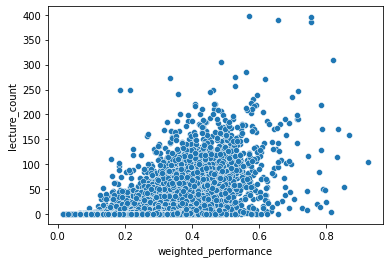

In [ ]:
ax = sns.scatterplot ( x=user_info['weighted_performance'], y=user_info['lecture_count'] )
print ( pearsonr(user_info['weighted_performance'], user_info['lecture_count']) )
print ( spearmanr(user_info['weighted_performance'], user_info['lecture_count'])) 

Есть ли зависимость между производительностью и средним затраченным на вопросы временем?

(-0.008249250290650812, 0.020767077207633204)
SpearmanrResult(correlation=-0.06582789941315115, pvalue=3.55417925571988e-76)


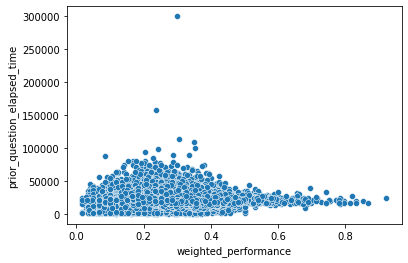

In [ ]:
ax = sns.scatterplot ( x=user_info['weighted_performance'], y=user_info['prior_question_elapsed_time']  )
from scipy.stats import pearsonr, spearmanr
print ( pearsonr(user_info['weighted_performance'], user_info['prior_question_elapsed_time']) )
print (  spearmanr(user_info['weighted_performance'], user_info['prior_question_elapsed_time']) )

Есть ли зависимость между производительностью и общим количеством попыток ответа?

(0.23683730807504982, 0.0)
SpearmanrResult(correlation=0.43856069817006066, pvalue=0.0)


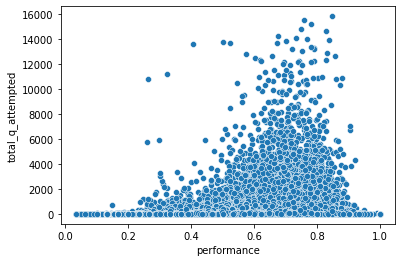

In [ ]:
ax = sns.scatterplot ( x=user_info['performance'], y=user_info['total_q_attempted']  )
print ( pearsonr(user_info['performance'], user_info['total_q_attempted']) )
print ( spearmanr(user_info['performance'], user_info['total_q_attempted'])) 

Наблюдаем хорошие корреляции между количеством просмотренных лекций, числом попыток и производительностью.

Исследуем столбец timestamp:

In [ ]:
import matplotlib.pyplot as plt

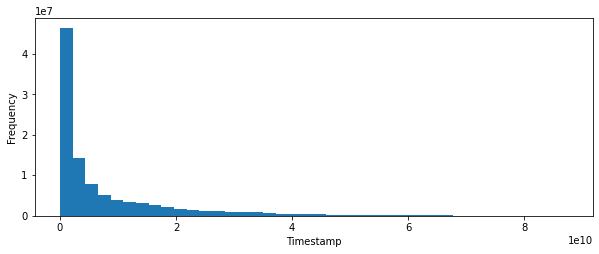

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.hist(train['timestamp'], bins = 40)
ax1.set_ylabel('Frequency')
ax1.set_xlabel("Timestamp")
plt.show()

На графике мы видим сильный перекос влево. Можем сделать вывод о том, что большинство пользователей сначала просматривали вопросы, а ответы на них давали позже.

Влияет ли тип вопроса TOEIC на количество правильных ответов?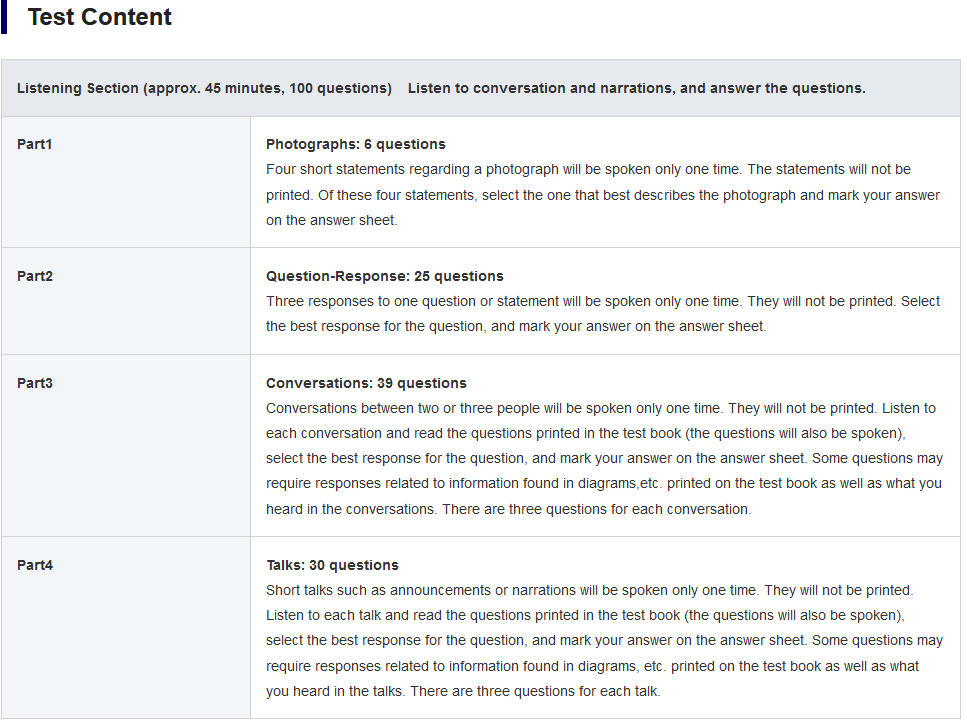

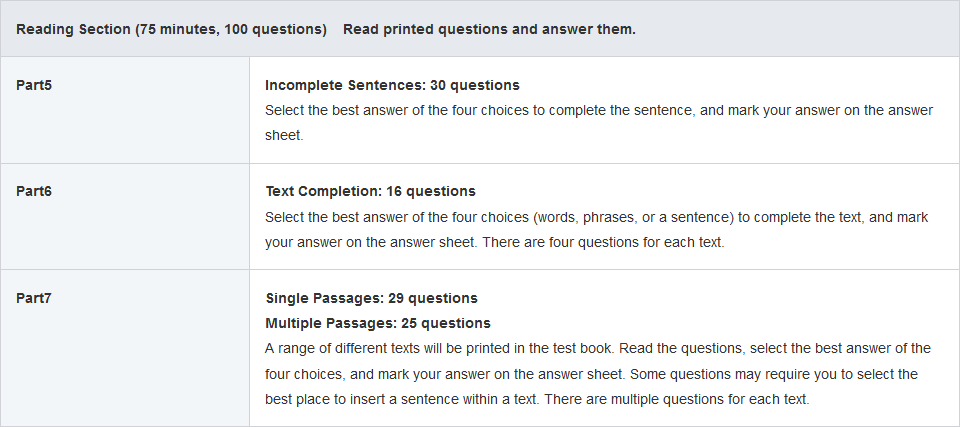

Присоединяем данные из questions к train:

In [ ]:
train= pd.merge(train,questions[['question_id','part']], how='left', left_on='content_id', right_on='question_id').sort_values('row_id')

Проводим очистку столбца с правильными ответами от лекций:

In [ ]:
train= train.loc[train['answered_correctly'] != -1].reset_index(drop=True)

Строим диаграмму корректности ответов в зависимости от того, к какой части экзамена относится вопрос:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


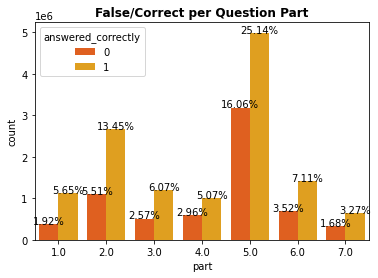

In [ ]:
g=sns.countplot(train.part, hue=train.answered_correctly, palette='autumn')
total = float(len(train.part))
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2.,
            height + 2,
            '{:1.2f}%'.format((height / total) * 100),
            ha='center')

plt.title('False/Correct per Question Part', weight='bold')
plt.show()

Из диаграммы можем сделать вывод о том, что ряд типовых вопросов вызывает сложности у студентов, в то время как глава 5 отличается высокими показателями правильных и неправильных ответов.

Какое количество лекций отведено каждой из частей TOEIC?

In [ ]:
lectures['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

Количество лекций, посвященных 5-ой главе, даёт дополнительное основание для предположения о том, что она отличается сложностью.

Влияет ли просмотр объяснения предыдущего вопроса на корректность ответов?

In [ ]:
train['prior_question_had_explanation']=train['prior_question_had_explanation'].astype('float')

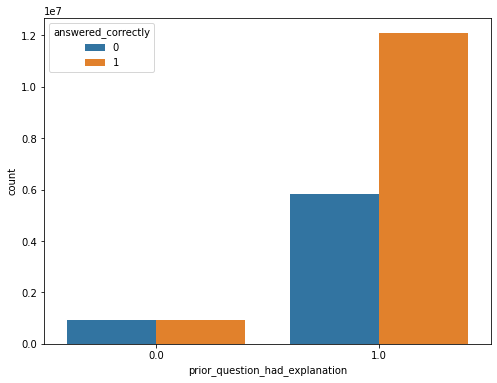

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.countplot(x="prior_question_had_explanation", hue="answered_correctly", data=train)

1.0==True, 0.0==False

Наблюдаем хорошую корреляцию между правильными ответами и просмотром объяснения предыдущего вопроса.

# **Выводы:**
*На основе вышеприведенного можно сделать вывод о том, что на успеваемости студентов сказываются сложность вопроса, количество просмотренных лекций, количество попыток ответа и просмотр ответа и объяснения для предыдущего вопроса.*